## Urban Audio Classification

![alt text][logo]

[logo]: https://static01.nyt.com/images/2013/10/24/nyregion/24cityroom-city-noise/24cityroom-city-noise-jumbo.jpg "City Noises"


### Introduction

We are in a world of sonic doom where noise pollution is one of the topmost quality of life issues for urban residents in the United States. It has been estimated that 9 out of 10 adults in New York City are exposed to excessive noise levels, i.e. beyond the limit of what the EPA considers to be harmful.

The objectives of this project is to evaluate and train various machine learning models to classify the urban sounds into categories correctly. 

Sonic event classification is a field of growing research. Most of these researches focuses on music or speech recognition. There are scarce works on environment sounds with very few databases for labeled environment audio data.


### Dataset

In this capstone project, [UrbanSound8K Audio Dataset](https://urbansounddataset.weebly.com) was used. The dataset is comprised of 8732 slices (audio excerpts) of up to 4 s in duration extracted from field recordings crawled from the Freesound online archive.

Each slice contains one of 10 possible sound sources: 
**air conditioner, car horn, children playing, dog bark, drilling, engine idling, gun shot, jackhammer, siren, street music.**

The sources were selected from the Urban Sound Taxonomy based on the high frequency with which they appear in noise complaints as determined from the data provided by New York City’s 311 service (over 370,000 complaints from 2010 to date)

Since these are real field-recordings, it is possible (and often the case) for there to be other sources present in a slice in addition to the labeled source. All slices have been manually annotated with the source ID and a subjective judgement of whether the source is in the foreground or background.

To facilitate comparable research, the slices in UrbanSound8K come pre-sorted into 10 folds using a stratified approach which ensures that slices from the same recording will not be used both for training and testing, which could potentially lead to artificially high results. 

### Problem Statement

Classify the audio files in urban setting and measure the performances of various models. 

- What feature extraction techniques should be used for optimal results?
- How do the machine learning models compare against the deep learning models?
- Which model performed the best? 


### Approach

1.	First, perform exploratory data analysis on the audio files to quickly assess audio patterns. 
2.	Preprocess the audio files. Use feature extraction techniques for audio feature generation and embedding post processing.
3.	Apply various machine learning based classification techniques to train the model to classify the audio file.
4.	Evaluate and choose the best performer by measuring the effectiveness of different models.


### Preprocessing

We used the VGG-like model to generate the 128-dimensional features using the [audioset](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) library available in the TensorFlow models Github repository, along with supporting code for audio feature generation, embedding postprocessing, and demonstrations of the model in inference and training modes.

View [jupyter notebook](https://github.com/rajinigurijala/Capstone4/blob/master/ExtractFeatures.ipynb) for extracting the audio features.


#### Feature Extraction

Feature extraction is the most important part for designing a machine learning model. 
To extract the useful features from sound data, we used Librosa and VGG Audioset library. These libraries provides several methods to extract different features from the sound clips. We explored the below mentioned methods to extract various features:

1.	Mel-frequency cepstral coefficients (MFCC)
    - This method is available in Librosa Library. 
    - It can extract 20-dimensional features from an audio file.
    - And is widely used in automatic speech and speaker recognition.


2.	Visual Geometry Group (VGG, also Known as VGGish)
    - This method is available in the Audioset Library.
    - It can extract 128-dimensional features from an audio file.
    - A pre-trained convolutional neural network.

These two methods were compared in the previous clustering project [Unsupervised Learning](https://github.com/rajinigurijala/Capstone4).

### Model Evaluation

After extracting the features, we will perform the following:

1. Analyze Support Vector Machine and Random Forest Classifier.
2. Hyperparamter tuning using both GridSearchCV and Validation Curve.
3. Choose the best model by reviewing the performance metrics.
4. Train the model using the best parameters.
5. Using the trained model, we will validate the test data to predict the audio classification.
6. Explore Tensorflow and Kera to see if the accuracy can be improved.

#### Hyperparameter Tuning
We will use various hyperparameter optimization techniques to find the best parameters:

- GridSearchCV
- KerasTuner
    - RandomSearch
    - Hyperband
- SciKit Optimize using gp_minimize


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix as sm
from scipy.spatial.distance import cdist
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse 
%matplotlib inline
import seaborn as sns
import os
import pickle
import scipy
from scipy.special import comb
plt.rcParams['figure.figsize'] = 15, 8
current_palette = sns.color_palette()
from timeit import default_timer as timer
from time import time
from datetime import datetime
from librosa import display
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc, silhouette_samples, silhouette_score
from sklearn.datasets import load_digits
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

### Load the pre-processed Urban 8k Audio Data Set

In [2]:
with open('all_features_data.p', 'rb') as f:
    vgg_data = pickle.load(f)


In [3]:
vgg_data.head(1)

,features,label,file_name,fold,salience,class,0,1,2,3,...,886,887,888,889,890,891,892,893,894,895
0,"[157.5, 12.5, 163.5, 111.25, 182.25, 32.5, 89....",3,UrbanSound8K/audio/fold1/101415-3-0-2.wav,1,1,dog_bark,157.5,12.5,163.5,111.25,...,0.0,0.922422,-0.502428,-0.341933,0.0,1.154701,-0.99787,0.0,-0.054023,0.0


In [4]:
vgg_data.shape

(8275, 902)

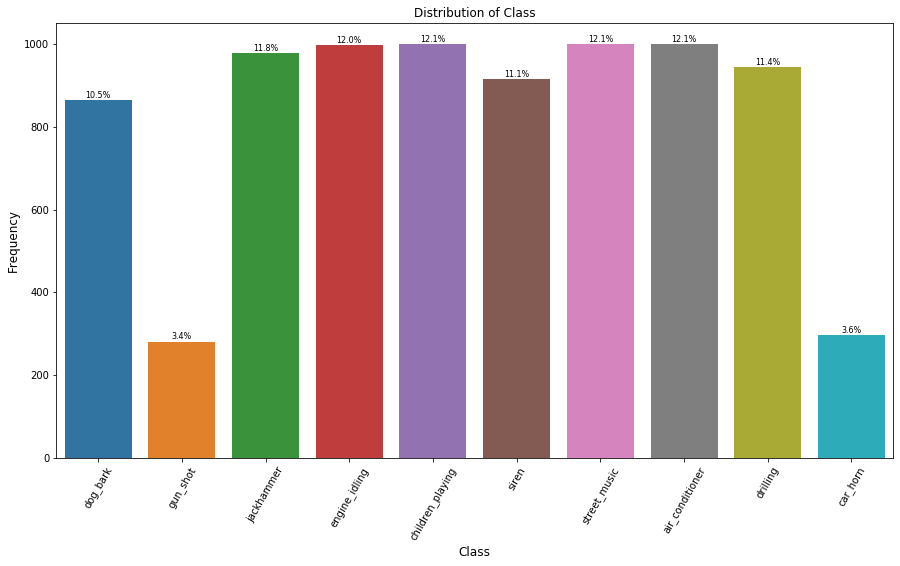

In [5]:
plt.rcParams["figure.figsize"] = [15, 8]

fig, ax = plt.subplots()
ax = sns.countplot(x = "class", data = vgg_data,
                 orient = "v")

plt.title('Distribution of Class')
plt.xlabel("Class",fontsize = 12);
plt.ylabel("Frequency",fontsize = 12);
plt.setp(ax.get_xticklabels(), rotation = 60)
for p in ax.patches:
  height = p.get_height()
  percent = ((height)/(len(vgg_data))) * 100
  ax.text(p.get_x()+p.get_width()/2.,
          height + 0.5,
          '%.1f' % percent + "%", ha = "center", va = "bottom", fontsize = 8)
plt.savefig('Class Distribution.png')

In [6]:
import IPython.display as ipd
ipd.Audio('UrbanSound8K/audio/fold1/7061-6-0-0.wav')

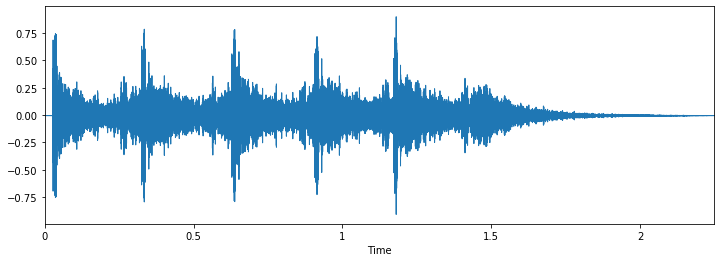

In [7]:
sample_data, sampling_rate = librosa.load('UrbanSound8K/audio/fold1/7061-6-0-0.wav')
plt.figure(figsize=(12, 4))
librosa.display.waveplot(sample_data, sr=sampling_rate)


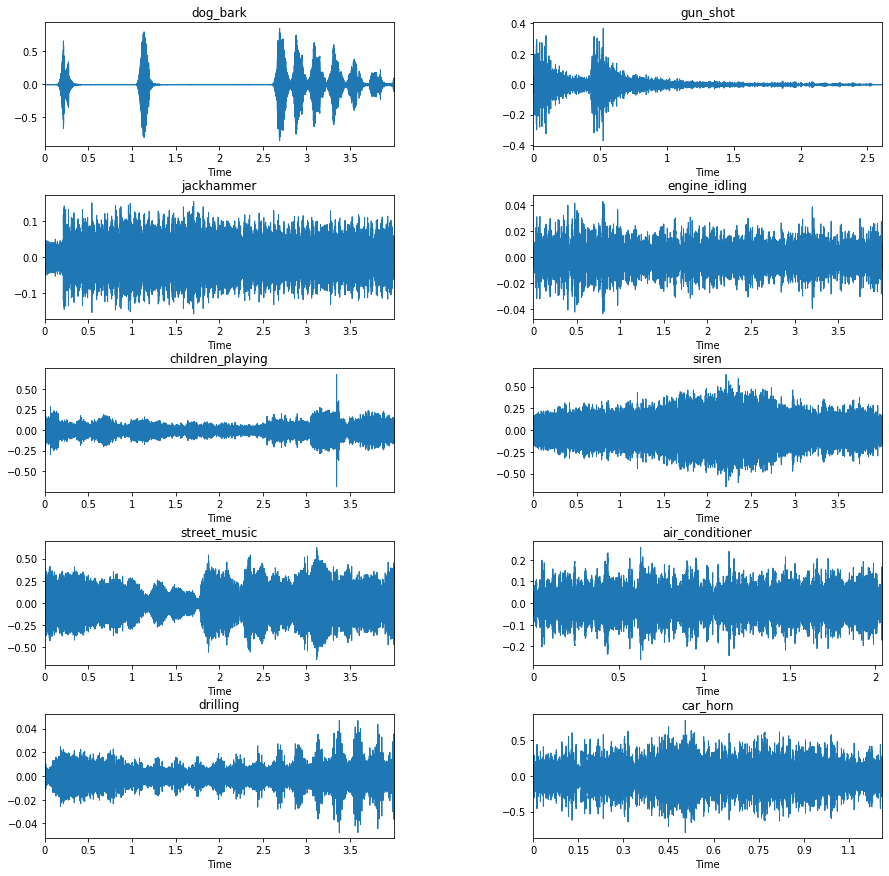

In [8]:
# Create a list of folder labels
fold_list = ((vgg_data['fold'].sort_values()).map(str)).unique().tolist()

# Create a list of the class labels
class_list = list(vgg_data['class'].unique())

# Let's grab a single audio file from each class
files = dict()
for i in range(len(class_list)):
    tmp = vgg_data[vgg_data['class'] == class_list[i]][:1].reset_index()
    path = '{}'.format(tmp['file_name'][0])
    files[class_list[i]] = path

fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(class_list):
    fn = files[label]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sample_rate = librosa.load(fn)
    librosa.display.waveplot(data, sr= sample_rate)
plt.savefig('Class Samples.png')


In [9]:
class_list

['dog_bark',
 'gun_shot',
 'jackhammer',
 'engine_idling',
 'children_playing',
 'siren',
 'street_music',
 'air_conditioner',
 'drilling',
 'car_horn']

In [10]:
vgg_data.dtypes

features      object
label         object
file_name     object
fold          object
salience      object
class         object
0            float64
1            float64
2            float64
3            float64
4            float64
5            float64
6            float64
7            float64
8            float64
9            float64
10           float64
11           float64
12           float64
13           float64
14           float64
15           float64
16           float64
17           float64
18           float64
19           float64
20           float64
21           float64
22           float64
23           float64
              ...   
866          float64
867          float64
868          float64
869          float64
870          float64
871          float64
872          float64
873          float64
874          float64
875          float64
876          float64
877          float64
878          float64
879          float64
880          float64
881          float64
882          

In [11]:
vgg_data['label']  = vgg_data['label'].astype('int64')

In [12]:
vgg_data[vgg_data['fold']>=8]['label'].head()

5940    3
5941    5
5942    5
5943    5
5944    3
Name: label, dtype: int64

In [13]:
vgg_data[vgg_data['fold']<8]['label'].tail()

5935    1
5936    1
5937    1
5938    1
5939    1
Name: label, dtype: int64

## Train Test Split

In [14]:
X = vgg_data.drop(columns = ['features','label','file_name','fold','salience','class'])
y = vgg_data['label']
X.shape,y.shape

((8275, 896), (8275,))

In [15]:
# Create training and test sets with 80% and 20% splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6620, 896), (1655, 896), (6620,), (1655,))

In [16]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,886,887,888,889,890,891,892,893,894,895
1425,180.00,46.00,211.50,124.25,250.75,69.25,86.75,139.75,158.00,248.75,...,0.000000,-0.483122,-1.154701,-1.111842,1.154701,-1.054061,-0.360699,-1.056338,0.560740,0.0
2865,155.50,28.25,132.25,67.00,249.50,70.00,117.50,55.50,103.50,206.75,...,-0.448948,-1.110596,0.444703,-0.969895,0.746170,0.390176,-0.150814,-0.059893,-0.931453,0.0
4500,160.50,39.75,178.75,111.25,255.00,67.00,105.50,107.00,170.25,186.75,...,0.000000,-0.761592,-0.208863,-1.146584,0.925785,0.530478,-1.065949,-0.393007,0.107303,0.0
7630,170.00,40.00,192.75,131.50,237.75,42.00,60.75,96.50,146.25,135.00,...,1.154701,1.154701,0.896919,0.556778,0.000000,1.154701,-1.095653,-0.986805,-0.666871,0.0
4288,177.75,44.50,198.75,128.00,238.75,51.25,55.75,97.25,147.75,206.50,...,0.000000,-0.007108,-0.146210,0.515658,0.000000,-0.182154,-0.323744,-1.055218,-1.154701,0.0


In [17]:
y_train.head()

1425    9
2865    0
4500    2
7630    2
4288    1
Name: label, dtype: int64

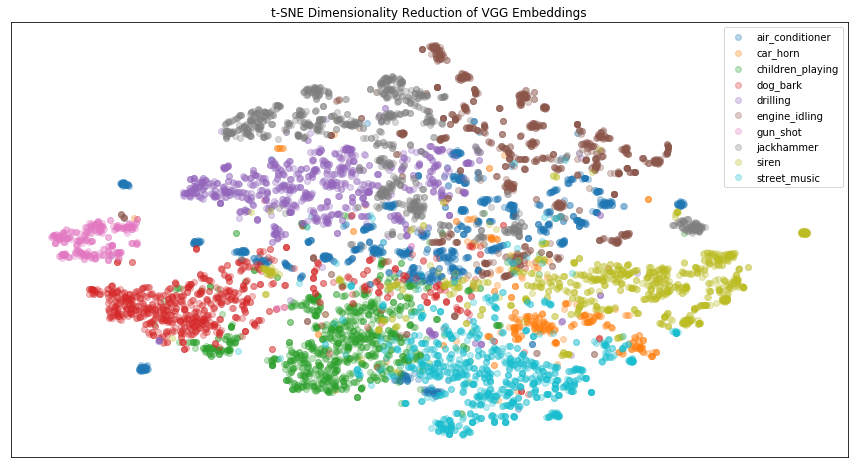

In [18]:
from sklearn.manifold import TSNE
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling',
           'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
tsne_vgg = TSNE(2)
U_vgg = tsne_vgg.fit_transform(X)
for i, cls in enumerate(classes):
    plt.scatter(U_vgg[y==i,0], U_vgg[y==i,1], label=cls, alpha=0.3, edgecolors=None)
plt.title('t-SNE Dimensionality Reduction of VGG Embeddings')
plt.xticks([])
plt.yticks([])
plt.legend();

### Model Evaluation

**Hyperparameter Optimization in Random Forest Classification**

1. n_estimators: The n_estimators parameter specifies the number of trees in the forest of the model (Default value is 10, which means that 10 different decision trees will be constructed in the random forest).
2. max_depth: The max_depth parameter specifies the maximum depth of each tree (Default value is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class).
3. min_samples_split: The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node (Default value is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification).
4. min_samples_leaf: The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node (Default value is 1, which means that every leaf must have at least 1 sample that it classifies).

In [19]:
# Define functions to select best parameters
def svc_param_selection(X, y, nfolds):
    Cs = [10, 100]
    gammas = [0.001, 0.0001]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_score_, grid_search.best_params_
def rf_param_selection(X, y, nfolds):
    parameters = { 
    'n_estimators': [300, 400, 750],
    'max_features': ['auto'],
    'max_depth' : [15, 20],
     'min_samples_split': [4],
    'criterion' :['entropy']
    }
    # Initialize and fit the model.
    rf = RandomForestClassifier(random_state=42)
    # Instantiate the grid search model with 10 folds
    grid_search = GridSearchCV(estimator = rf, param_grid = parameters, cv = nfolds, n_jobs = -1, verbose = 2)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_score_, grid_search.best_params_

In [20]:
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### 1. Support Vector Machine (SVM) Model

In [21]:
svbs, svbp = svc_param_selection(X_train, y_train, 10)
print('Best Score = {}, and Best Parameters = {}'.format(svbs, svbp))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.6min finished


Best Score = 0.9246223564954683, and Best Parameters = {'C': 100, 'gamma': 0.001}


*SVM Model gave 92.46% accuracy on training data set and 93% on the test data set.*

#### Train the SVM model with best parameters

In [22]:
from sklearn.svm import SVC
svc_model = SVC(kernel='rbf', C=100, gamma=.001)
modelSV = svc_model.fit(X_train, y_train)


In [23]:
svm_score = svc_model.score(X_train, y_train)

#### SVM Classification Report and Confusion Matrix

In [24]:
# Test the model
y_predSV = svc_model.predict(X_test)

In [25]:
print("Classification report for SVM classifier %s:\n%s\n"
      % (modelSV, classification_report(y_test, y_predSV)))

Classification report for SVM classifier SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       204
           1       0.93      0.95      0.94        59
           2       0.91      0.91      0.91       203
           3       0.92      0.92      0.92       180
           4       0.93      0.94      0.94       208
           5       0.96      0.91      0.93       186
           6       1.00      0.98      0.99        53
           7       0.96      0.93      0.95       195
           8       0.95      0.91      0.93       175
           9       0.91      0.96      0.93       192

    accuracy                           0.93      1655
   macro avg       0.94      0.93      0.93      1655
weight

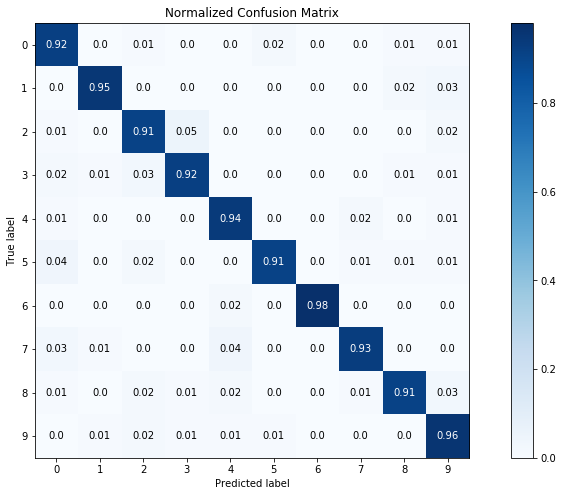

<Figure size 1080x576 with 0 Axes>

In [26]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, y_predSV, normalize=True)
plt.show()
plt.savefig('SVM_Confusion_Matrix.png')

### 2. Random Forest Model

In [27]:
rfbs, rfbp = rf_param_selection(X_train, y_train, 10)
print('Best Score = {}, and Best Parameters = {}'.format(rfbs, rfbp))

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 48.1min finished


Best Score = 0.8962235649546828, and Best Parameters = {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 750}


*Random Forest Model gave 89.62% accuracy on the training data set.*

#### Plot Validation Curve for Random Forest

One can also choose which hyperparameters to adjust for the model using a validation curve which allows us to visually check for potentially optimized values of model hyperparameters. 

In [28]:
def plot_val_curve(pname, prange):
    
    ##### Create range of values for parameter
    param_range = prange

    # Calculate accuracy on training and test set using range of parameter values
    train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                                 X_train, 
                                                 y_train, 
                                                 param_name=pname, 
                                                 param_range=param_range,
                                                 cv=10, 
                                                 scoring="accuracy", 
                                                 n_jobs=-1)


    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot mean accuracy scores for training and test sets
    plt.plot(param_range, train_mean, label="Training score", color="black")
    plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

    # Plot accurancy bands for training and test sets
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="gainsboro")

    # Create plot
    plt.title("Validation Curve With Random Forest")
    plt.xlabel("Number Of Trees")
    plt.ylabel("Accuracy Score")
    plt.tight_layout()
    plt.legend(loc="best")

A validation curve can be plotted on a graph to show how well a model performs with different values of a single hyperparameter. In this case we are checking for *n_estimator* hyperparamtere with values between 300 to 800 and try to find the optimal value.

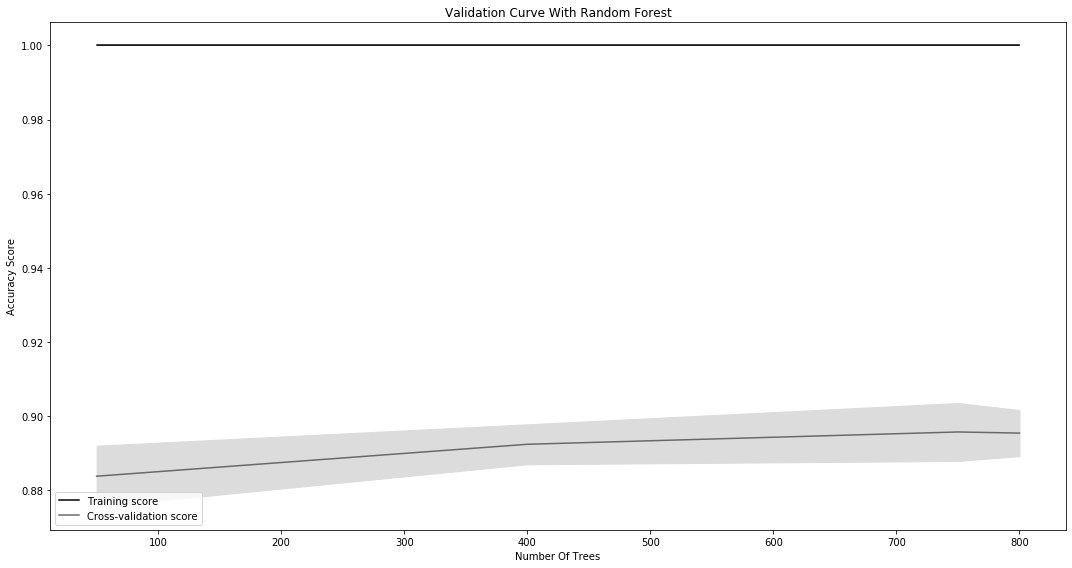

In [29]:
prange = [50, 400, 750, 800]
pname = "n_estimators"
plot_val_curve(pname, prange)

In this plot, we see that, when testing the values, the best value appears to be **750**. It is important to note that, even though there appears to be a large difference between the training and cross-validation score, the training set had an average accuracy of 100% for each of the ten cross-validations, and the cross-validation set had between **89.2% and 89.4%** accuracy for all the values of n_estimators, which shows that this model is very accurate regardless of the number of estimators used.

We can also try plotting different values for *the max_depth and min_samples_split*.

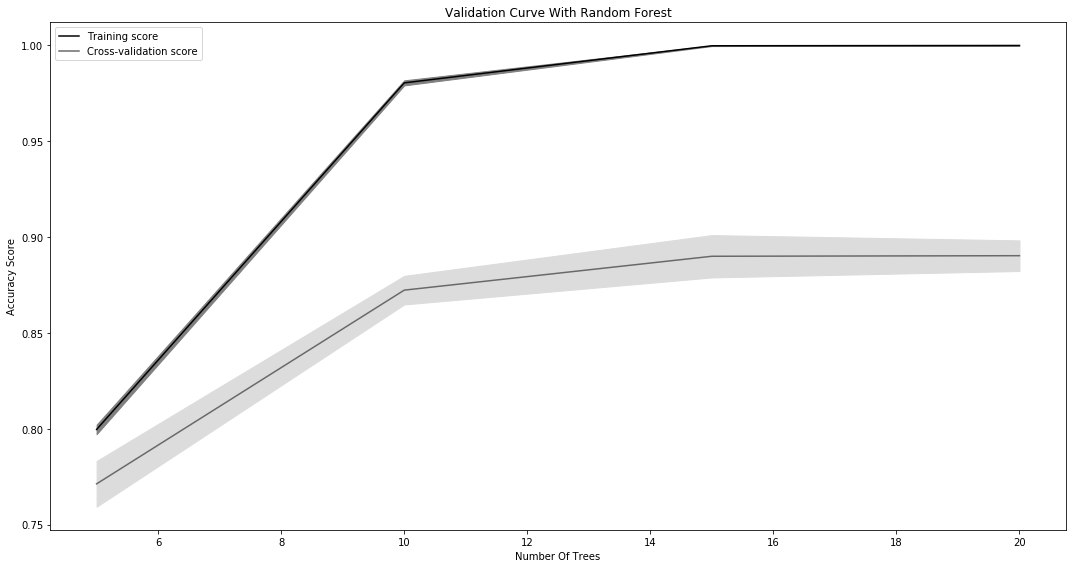

In [30]:
# Create range of values for parameter
prange = [5, 10, 15, 20]
pname = "max_depth"
plot_val_curve(pname, prange)

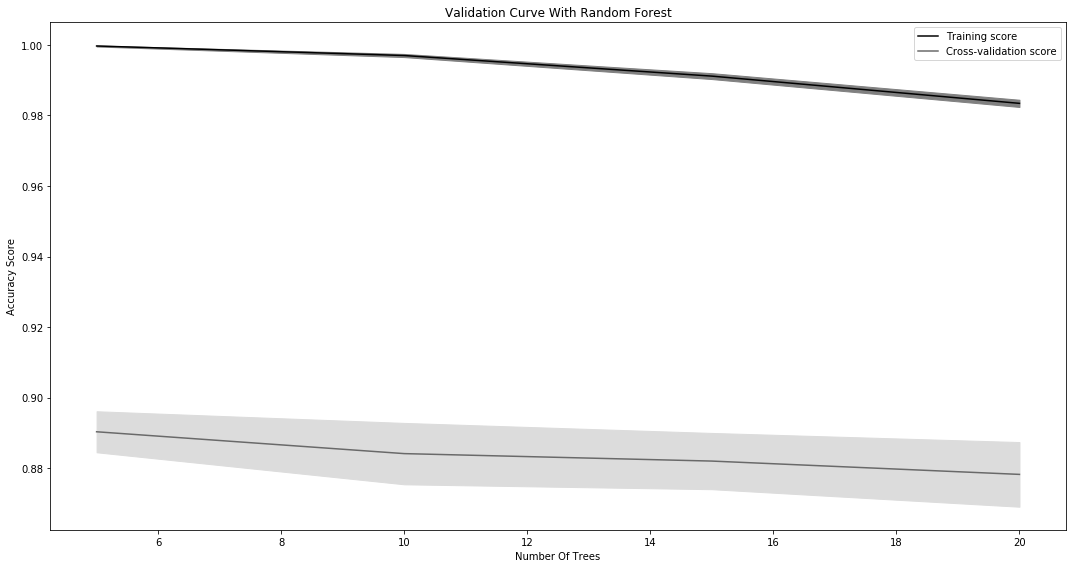

In [31]:
# Create range of values for parameter
param_range = [3, 4, 5, 6]
pname = "min_samples_split"
plot_val_curve(pname, prange)

#### Train the RF model with best parameters

In [32]:
#best_model = rs.best_estimator_

random_forest = RandomForestClassifier(criterion = 'entropy', max_depth=15, max_features = 'auto', min_samples_split = 4, n_estimators=750)
modelRF = random_forest.fit(X_train, y_train)

rf_score = svc_model.score(X_train, y_train)
print('RF Training Score =',rf_score)

RF Training Score = 1.0


In [33]:
# Test the model
y_predRF = modelRF.predict(X_test)


*Random Forest Model gave 89.62% accuracy on the test data set.*

#### RF Classification Report and Confusion Matrix

In [34]:
print("Classification report for Random Forest classifier %s:\n%s\n"
      % (modelRF, classification_report(y_test, y_predRF)))

Classification report for Random Forest classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=750,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       204
           1       0.88      0.76      0.82        59
           2       0.87      0.90      0.89       203
           3       0.92      0.89      0.91       180
           4       0.90      0.92      0.91       208
           5       0.92      0.89      0.91       186
           6       0.

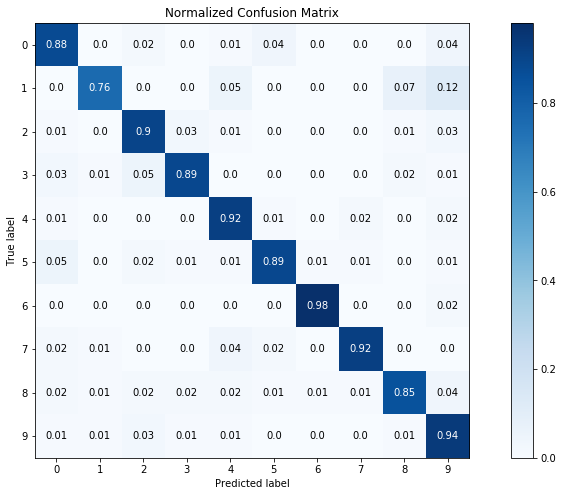

<Figure size 1080x576 with 0 Axes>

In [35]:
import scikitplot as skplt
plt.rcParams['figure.figsize'] = 15, 8
skplt.metrics.plot_confusion_matrix(y_test, y_predRF, normalize=True)
plt.show()
plt.savefig('RF_Confusion_Matrix.png')

### 3. Deep Neural Network

#### Hyperparameter Optimization - GridSearchCV

View jupyter notebook for evaluating DeepNN with [GridSearchCV](https://github.com/rajinigurijala/FinalCapstone/blob/master/UrbanSoundKeras_GridSearch.ipynb) hyperparameter optimization.

*Results:*
- DeepNN Model accuracy on the training data set is 86.9% whereas on the test data set it is 80.6%. 
- The train loss score and test loss score are 0.399 and 0.738 respectively.
- This model has overfitting issue as the train set accuracy is higher than the test set acccuracy. 

#### Hyperparameter Optimization - Keras Tuner 

View jupyter notebook for optimizing and evaluating DeepNN with [Keras Tuner](https://github.com/rajinigurijala/FinalCapstone/blob/master/UrbanSoundKeras_Tuner.ipynb) using RandomSearch and Hyperband.

*Random Search Results:*

- DeepNN Model accuracy on training data is 99% whereas on the test data set it is 82.2%.
- The train loss score and test loss score are 0.394 and 0.85 respectively.
- This model has overfitting issue as the train set accuracy is higher than the test set acccuracy. 

*Hyperband Results:*

- DeepNN Model accuracy on training data is 98.15% whereas on the test data set it is 82.5%.
- The train loss score and test loss score are 0.07 and 0.88 respectively.
- This model has overfitting issue as the train set accuracy is higher than the test set acccuracy.

### 4. Convolutional Neural Network

#### Hyperparameter Optimization using Sci-Kit Optimize

View jupyter notebook for optimizing and evaluating CNN with [Sci-Kit Optimize](https://github.com/rajinigurijala/FinalCapstone/blob/master/UrbanSoundKeras_CNN.ipynb).

*Results:*

- CNN Model accuracy on training data is 88.36% whereas on the test data set it is 79.91%.
- The train loss score and test loss score are 0.07 and 0.88 respectively.
- This model has overfitting issue as the train set accuracy is higher than the test set acccuracy.


### Final Thoughts

**Conclusions**

We trained 4 different models with hyperparameter optimization – Support Vector Machine, Random Forest, Deep Neural Networks and Convolutional Neural Networks.

**Model Comparison**

|   Model   |   Hyperparameter Optimization Type   |   Training Accuracy   |   Test Accuracy   |   Issues   |   Best Score   |
|:--------------|:--------------|:--------------|:--------------|:--------------|:--------------|
| Support Vector Machine  |   GridSearchCV  |    92.46%   |    93.00%  |   -   |   Gunshot had the highest score of 100%  |
| Random Forest  |   GridSearchCV  |    89.62%   |    90.00%  |   -   |   Gunshot had the highest score of 96%   |
| Deep Neural Network  |   GridSearchCV  |    86.90%   |   80.60%   |  Overfitting   |   Gunshot had the highest score of 100%   |
| Deep Neural Network  |   Keras Tuner - RandomSearch   |   99.00%   |    82.20%  |  Overfitting    |   Gunshot had the highest score of 100%   |
| Deep Neural Network  |   Keras Tuner - Hyperband   |   98.15%   |    82.50%  |  Overfitting  |   Gunshot had the highest score of 100%   |
| Convolutional Neural Network |   Sci-Kit Optimize   |   88.36%   |    79.91%  |  Overfitting   |   Car horn had the least score of 42%   |

**Key Findings**

- Support Venctor Machine SVM model performed better than all others with training and test accuracy of 93% followed by the Random Forest model with 89% accuracy. 

- Both DNN and CNN seems to have overfitting issues based on their test accuracy score lower than the training accuracy score.

- Having the lowest number of samples, gunshot is still managed to have the highest proportion for true positive value for all the models.

- Car horn and gun shot have less than 300 samples compare to other classes, which have around 1000 samples each

**Practical Uses**

The automatic classification of audio events in an urban setting has a wide range of applications in areas such as, 

- Audio Event Detection
- Audio Music Tagging
- Audio Fingerprinting
- Music Retrieval
- Music Recommendation
- Home security or Audio Surveillance
- Assisted living, elder or infant care
- Accident and crime surveillance

For example, a baby crying, a person screaming, people arguing that may lead to violence, sound of a gunshot/explosion or someone calling for help are just some audio events that require action. Manually monitoring for these sounds, either in close proximity or remotely through a monitoring device, not only demands attention but also requires the person to be within hearing distance. This is not always possible, and is where audio event detection, or sound recognition, solves real problems. It will automatically alerts an application if a specific sound is detected, so that a human may take the appropriate action. Other applications of this project includes music classification, detecting sounds of different species for wildlife preservation etc. without engaging human resources to classify them.

**Future Considerations**

This capstone project focuses on the various machine learning techniques to model the data to give us predictive power to classify the sonic events accurately. Improving this model to optimize prediction of the audio classification includes supervised machine learning models such as Random Forest, and Support Vector Machines as well as neural network models such as Deep Neural Networks and Convolutional Neural Networks using TensorFlow and Keras.

By modeling and interpreting the data, we can potentially improve the quality of life of city dwellers by providing a data-driven understanding of urban sound and noise patterns, partly enabled by the move towards “smart cities” equipped with multimedia sensor networks.

We can plan to integrate the proposed system with an audio based searching system and observe the performance of the same in various scenarios.


**References**

1.	[VGGish Audio Embedding Colab](https://colab.research.google.com/drive/1TbX92UL9sYWbdwdGE0rJ9owmezB-Rl1C#scrollTo=DaMrmOEvC7L4)
2.	[Hyperparameter Optimization in TensorFlow](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/19_Hyper-Parameters.ipynb)
3.	[Hyperparameter Tuning using Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner)
4.	[Jupyter Markdown Cheat sheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)


**Technologies Used**

- Python, Numpy, Pandas, Matplotlib, Seaborn, Sci-Kit Learn, Librosa, Audioset
- Jupyter Notebook
